In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import networkit as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import phate

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from External.WS_Tree_dist import EMD_dist_tree_discretized, EMD_dist_tree_edge, plot_flow_discretized
from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp
from External.generation import create_graph

plt.style.use('standard.mplstyle')

# Hyperparameters
mode = "Full+Exp-Triangle"   # mode for the graph construction
gamma = 120                    # Gamma for the triangle break

metric = "euclidean"         # Metric for the k-means clustering
ε, δ = 0.03, 0.1             # Values for the estimation of the k for k-means

title_of_ICT = "triangle break (exponential, γ=120)"
name_of_image = "triangle_break/2d_phate_exp_120"

In [2]:
# Load the data

position, labels = phate.tree.gen_dla(n_dim=2, n_branch=3,
                                            branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
labels_unique = np.unique(labels)


position = StandardScaler().fit_transform(position)
number_of_nodes = len(position)

In [3]:
embedding = position

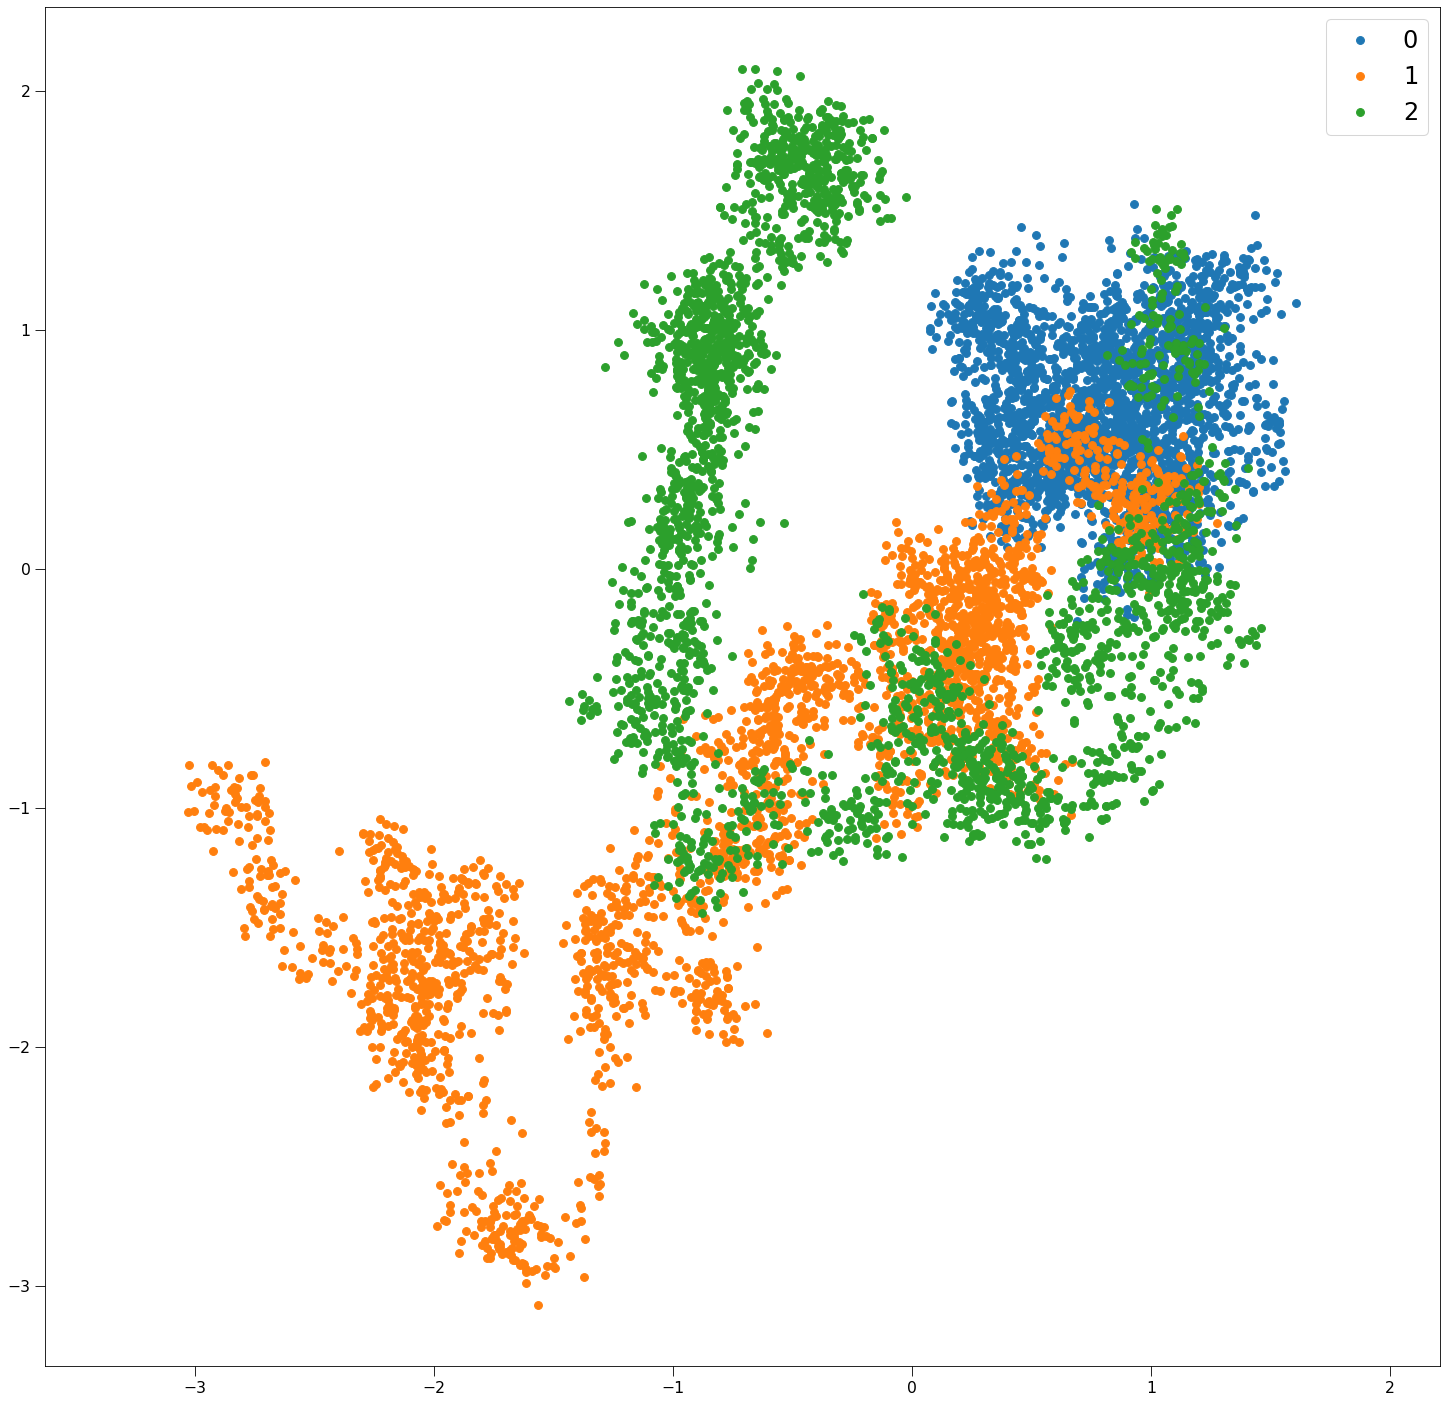

In [4]:
fig, ax = plt.subplots(1,1, figsize=(24,24))
for label in labels_unique:
    plt.plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
ax.axis("equal")
plt.legend()
plt.show()

In [5]:
# Create the graph
start = time.time()
G, position = create_graph(number_of_nodes, mode, position=position, gamma=gamma)
G.indexEdges()
print(time.time()-start)


18.153847455978394


In [6]:
start = time.time()
# calculate the clusters
r = 1 / (ε**2) * (int(np.log2(number_of_nodes - 1)) + 1 + np.log(1/δ))
k = int(np.sqrt(r))
k = np.min((k, G.numberOfNodes()))
cluster_centers = k_means_pp(k, position, metric=metric, G=G)
print(time.time()-start)

2.9695658683776855


In [7]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT.indexEdges()

# widths of the edges
widths = compute_widths(ICT)
print(time.time()-start)

update Arr 28121250 -> 10078
added 606 edges early
update Arr 10078 -> 9161
added 392 edges early
update Arr 9161 -> 8324
added 416 edges early
update Arr 8324 -> 7567
added 571 edges early
update Arr 7567 -> 7508
added 42 edges early
update Arr 7508 -> 7507
update Arr 7507 -> 7499
added 6 edges early
added 3601 edges early

2623.0988759994507


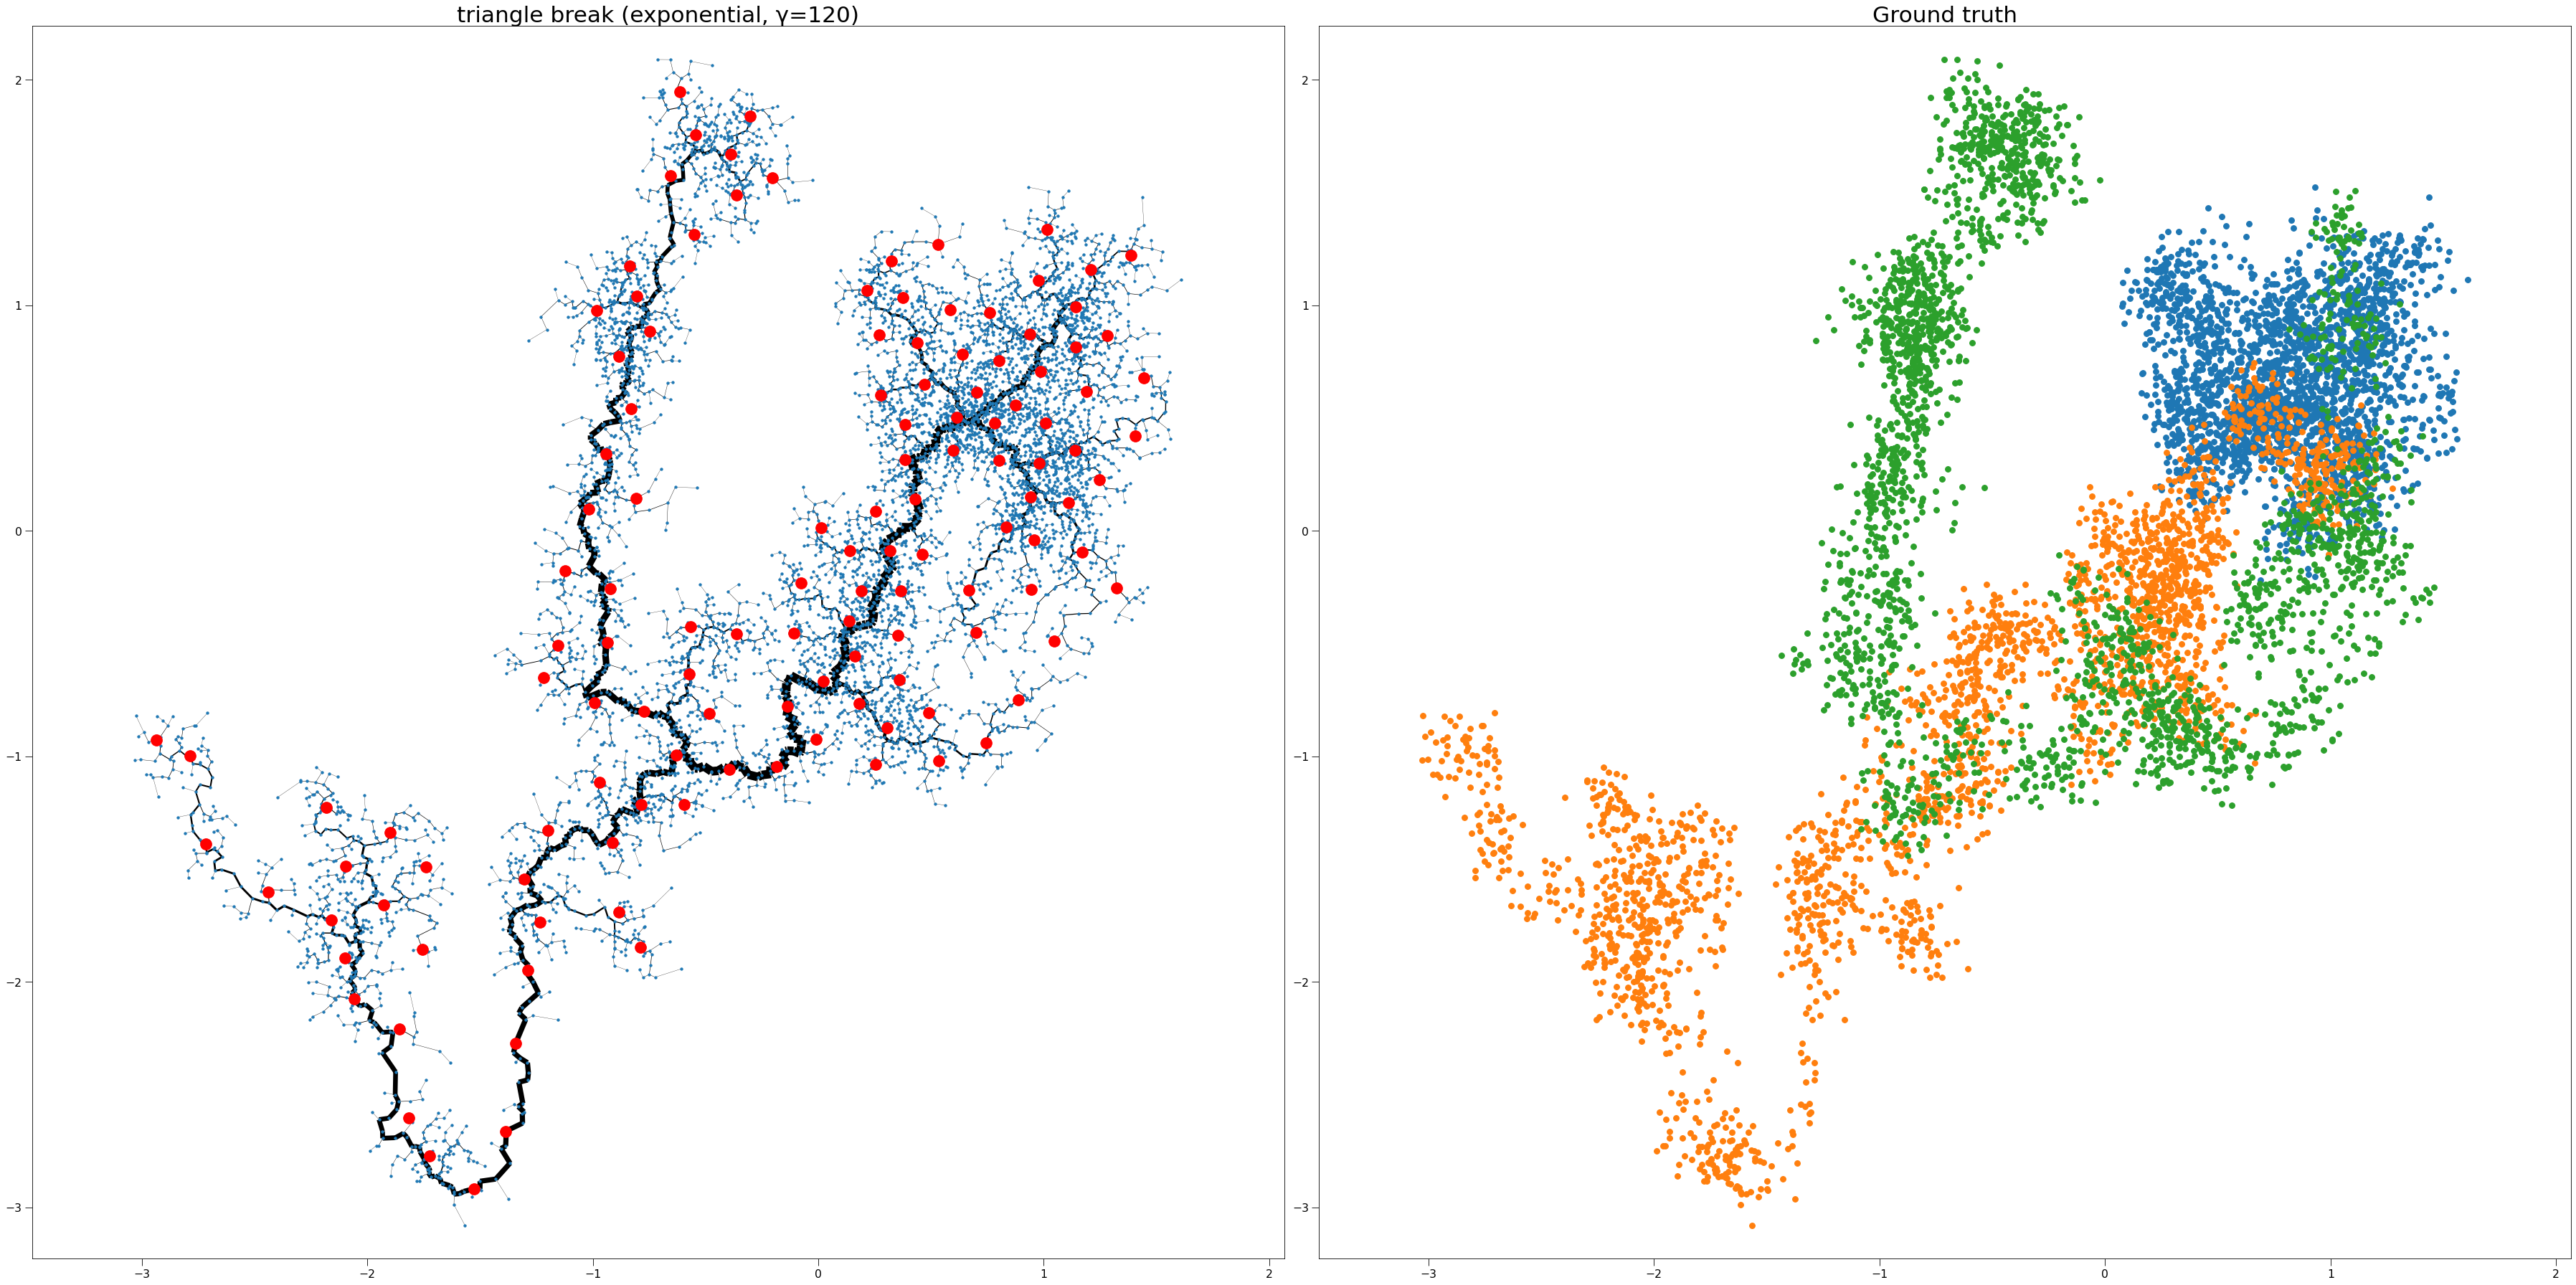

In [8]:
# plotting

names = [title_of_ICT, "Ground truth"]
number_of_plots = len(names)



# Create the figure
fig, ax = plt.subplots(1, 2, figsize=(24*2,24))
    
# Plot the ICT and the cluster centers
nk.viztasks.drawGraph(ICT, pos=embedding, ax=ax[0], width=widths, node_size=10)
ax[0].plot(*embedding[cluster_centers].T, marker="o", color = "Red")

# Plot the ground truth
for label in labels_unique:
    ax[1].plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
    
# General stuff
for i in range(number_of_plots):
    ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[i].set_axis_on()
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.legend
plt.tight_layout()
plt.savefig(f"./Output/Images/{name_of_image}.png")
plt.show()

# Compare to the plain mst

In [9]:
# Create the graph
start = time.time()
G, position = create_graph(number_of_nodes, "Full", position=position, gamma=gamma)
G.indexEdges()
print(time.time()-start)


16.741973161697388


In [10]:
from copy import deepcopy
G_inv = deepcopy(G)
for u,v,w in tqdm(G.iterEdgesWeights(), total=G.upperEdgeIdBound()):
    G_inv.setWeight(u, v, 1/w)

In [11]:
MST = nk.graph.RandomMaximumSpanningForest(G_inv)
MST.run()
mst = MST.getMSF(True)

In [12]:
mst.indexEdges()
widths_mst = compute_widths(mst)

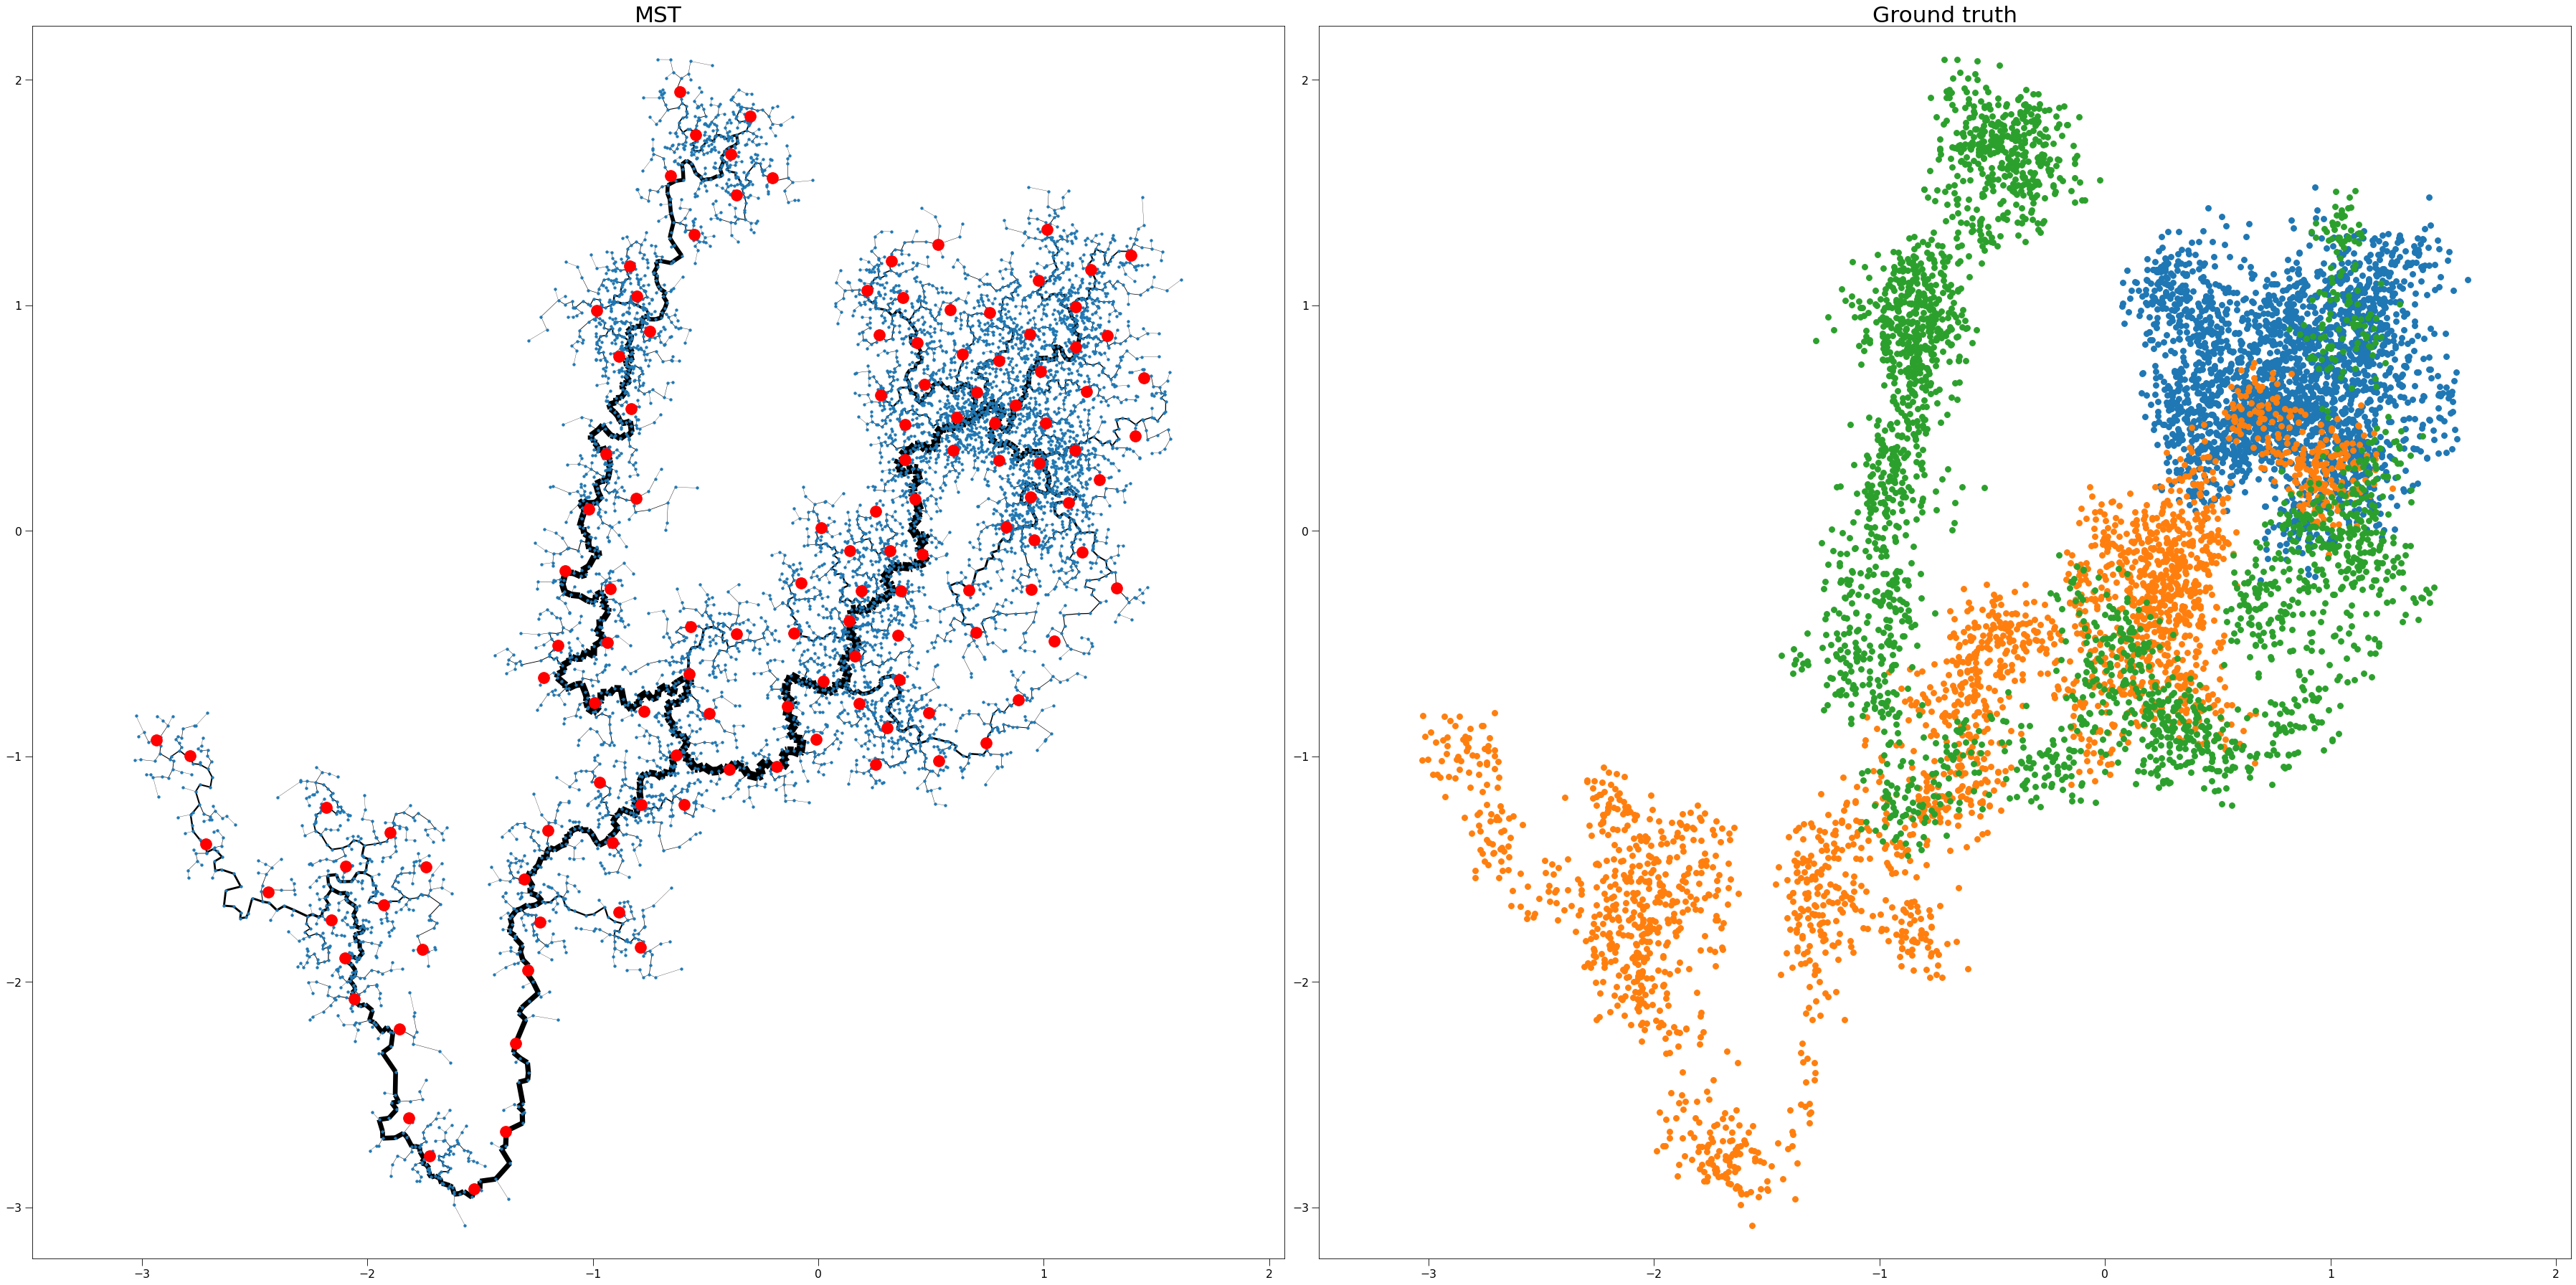

In [13]:
# plotting


names = ["MST", "Ground truth"]
number_of_plots = len(names)



# Create the figure
fig, ax = plt.subplots(1, 2, figsize=(24*2,24))
    
# Plot the ICT and the cluster centers
nk.viztasks.drawGraph(mst, pos=embedding, ax=ax[0], width=widths_mst, node_size=10)
ax[0].plot(*embedding[cluster_centers].T, marker="o", color = "Red")

# Plot the ground truth
for label in labels_unique:
    ax[1].plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
    
# General stuff
for i in range(number_of_plots):
    ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[i].set_axis_on()
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.legend
plt.tight_layout()
plt.savefig(f"./Output/Images/triangle_break/MST_2d_phate.png")
plt.show()